# Motivation

The opening of society during an active Covid19 pandemic means reproductive rate $R_0$ is a function of time $R_0 \rightarrow R_0(t)$. In an effort to gain insight to possible reopening methods and consequences of demographic stochasticity. As such a model is needed with the ability to paramaterize the spread rate to an observable. It is common to use the confirmed cases as a metric, but historical under reporting during other epidemics makes it unceartain. Instead we will attempt to relate other data such as the number of deaths and the hospitalization data to parameterize $R_0$.

## Basic SEIR Model

Current concensus among medical research suggest that the incubation time for Covid19 has a typical range of $\tau_inc = \in [2,14]$ days(CITE). As such we will include the exposed population function. 4 populations are tracked, namely Susceptable $X(t)$, Exposed $Y(t)$, Infectious $Z(t)$, Removed $W(t)$. These have the dimention of population and the sum gives the total population, 

$$X + Y + Z + W = N$$

The following assumptions are made regarding changing populations. Any change in *susceptible* population is a result of birth/deaths or exposure to the infection. People catagorized as *exposed* either die of natural causes or enter an *infectious* period. Those that become infectious either recover or die as a result of the virus or by natural cuases. Finally, the *removed* population can only decrease from natural causes. Equation for rates of change in S, E, I, R can be written

$$\frac{dX}{dt} = \mu N - X \left( \beta \frac{Z}{N} + \mu \right) $$

$$\frac{dY}{dt} = \beta \frac{X Z}{N} - Y(\sigma + \mu) $$

$$\frac{dZ}{dt} = \sigma Y - Z(\gamma + \mu) $$

$$\frac{dW}{dt} = \gamma Z - \mu W$$

Dividing out the size of the populations by N allows for simplification (Keeling p. 17). We define


$$ S \equiv X/N$$
$$ E \equiv Y/N$$
$$ I \equiv Z/N$$
$$ R \equiv W/N$$



A further simplification allows us to remove all terms with $\mu$. $\beta$ and $\gamma$ are both of order $10^{-1} [1/{\text(day)}]$ while for the united stated $\mu$ is of order $1 10^{-5}[1/{\text(day)}]$ allowing all all terms with $\mu$ to be be dropped. This leaves the simpler set of equations: 

$$\frac{dS}{dt} = \beta S I $$

$$\frac{dE}{dt} = \beta S I - \sigma E $$

$$\frac{dI}{dt} = \sigma E - \gamma I $$

$$\frac{dR}{dt} = \gamma I$$




### Function Arguements

Above the rates moving people from one category to another are taken to be constant.Eventually, we will add a driving function which varies over time. A list of the variable and thier meaning follows:
 
- $\beta$ = *Contact frequency* $\approx  \frac{1}{3}[T^{-1}] $
- $\sigma$ = *Latent frequncy* $[T^{-1}]$
- $\gamma$ = *Removal frequency* $[T^{-1}]$

The only known variable is $\mu$, found using US cencus population data for average life expectancy, the rate is the inverse. The rest must be inferred from fitting reported observables.



### Basic Reproduction Number $R_0$

The basic reproduction number, $R_0$ is widely employed to describe the growth of a pandemic. Define by (Cite), $R_0$ is the average number of secondary cases arising from an average primary case in an entirely susceptible population. $R_0$ is the inverse of the relative removal rate. It helps to consider the SIR model where now exposed and infectious populations are reduced to a single infected population, $G$. If we make a ratio of the rates decreasing $G$ and those increasing, we obtain $R_0^{-1}$. 

$$ G = I + E $$

$$ \frac{dG}{dt} = \frac{dI}{dt} + \frac{dE}{dt}$$

$$ \frac{dG}{dt} = \beta \frac{S I}{N} - (\mu(E+I) + I\gamma)$$ 

Now that we have a clear distinction for increasing $G^+$ and decreasing $G^-$ terms we can find the inverse of $R_0$. Also notice that the reproductive rate includes deaths not directly resulting from the infection.

$$ R_0^{-1} = \frac{G^-}{G^+}$$

$$ R_0^{-1} = \frac{\mu(E+I) + I\gamma}{\beta \frac{S I}{N}}$$

$$ R_0^{-1} = \frac{\mu G + I\gamma}{\beta S I} N$$

$$ R_0^{-1} = N\frac{\gamma}{\beta S} + N\frac{\mu G}{\beta S I} $$

$$ R_0^{-1} = \frac{N}{S} \left( \frac{\gamma}{\beta} + \frac{\mu G}{\beta I} \right) $$

The above form for $R_0^{-1}$ is reminescent of an expansion, where if the second term is sufficiently small we can approximate the reproductive rate as the following. 

$$ R_0 = \frac{\beta}{\gamma} \frac{S}{N} $$

Later, demographic effects can be modelled by introducing a contact driving function. Implimented counter spread measures can be modelled by breaking the pandemic into different timme periods with varying $R_0$ values or functions of time, $R_0(t)$.

## Modelling SEIR

The set of ODE's can be easily solved using scipy's *odeint()*. The first requirement is to make a function which supplies the system of equations and an initial value array.

In [1]:
import pylab as py
from scipy.integrate import odeint

In [2]:
N = 1
I0 = 0.0
E0 = 0.001
R0 = 0.0
S0 = N - I0 - E0
initial_c = S0, I0, E0, R0

def diff_eqs(Init, t, m, b, s, g):
    S, E, I, R = Init # Initial conditions
    dSdt = m * N - S * (b * (I/N) + m) # Change in susceptible population
    dEdt = b * I * S / N - E * (s + m) # Change in Exposed population
    dIdt = s * E - I * (g + m) # change in Infected population
    dRdt = g * I - m * R # Change in removed individuals
    return dSdt, dEdt, dIdt, dRdt

We must also create an array to pass time and list of arguements for *diff_eqs*. The arguements used here are taken from (cite cyclic paper, page 8), and $R_0=1.5$. Later, $\beta$ can be derived using our equation for $R_0$ and reported values for the infectious period, $\gamma^{-1}$.

In [3]:
dt = 1/24; t0 = 0; tmax = 100 # days|
time = py.arange(t0, tmax+dt, dt)

R_0 = 1.2
m = 1/78.6 # the population does not grow 1%/ day... more like .6%/yr...
g = 1/4; 
s = 1/3; 
b = R_0/g #* N/S0 #what is this about?
args = m, b, s, g

We are ready to obtain our solution for the SEIR model. The following code solves the system of equations derived for the SEIR model. Results are plotted, where the total population is scaled to 1.

In [4]:
solution = odeint(diff_eqs, initial_c, time, args=(m, b, s, g))
S, E, I, R = solution.T

### Plotting SEIR

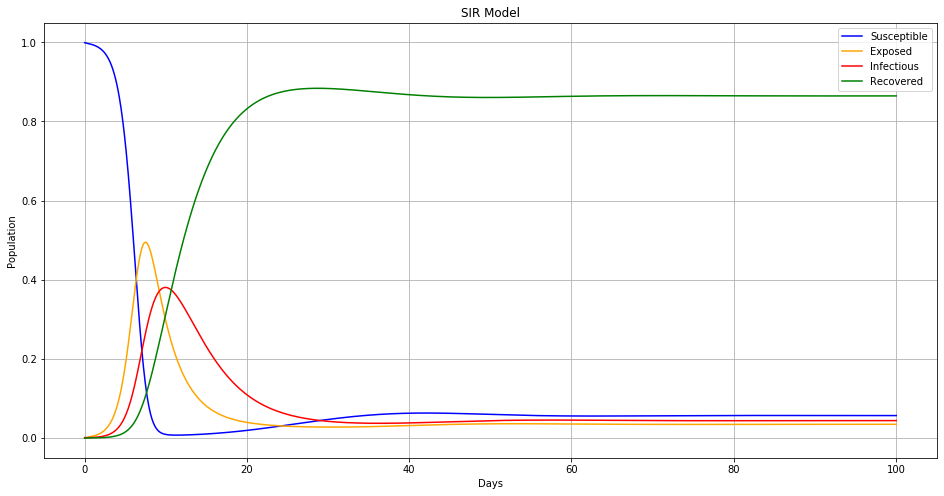

In [5]:
# Plot the results to verify model works
title = 'SIR Model'
py.close('all')
py.figure(figsize=(16,8))
py.title(title)
py.plot(time, S, color='blue', label='Susceptible', linewidth=1.5)
py.plot(time, E, color='orange', label='Exposed', linewidth=1.5)
py.plot(time, I, color='red', label='Infectious', linewidth=1.5)
py.plot(time, R, color='green', label='Recovered', linewidth=1.5)
py.legend(frameon=True)
py.xlabel('Days'); py.ylabel('Population'); py.grid()
py.show()